# 第7章: 機械学習

本章では、[Stanford Sentiment Treebank (SST)](https://nlp.stanford.edu/sentiment/) データセットを用い、評判分析器（ポジネガ分類器）を構築する。ここでは処理を簡略化するため、[General Language Understanding Evaluation (GLUE)](https://gluebenchmark.com/) ベンチマークで配布されているSSTデータセットを用いる。


## 60. データの入手・整形

GLUEのウェブサイトから[SST-2](https://dl.fbaipublicfiles.com/glue/data/SST-2.zip)データセットを取得せよ。学習データ（`train.tsv`）と検証データ（`dev.tsv`）のぞれぞれについて、ポジティブ (1) とネガティブ (0) の事例数をカウントせよ。

In [ ]:
# !wget https://dl.fbaipublicfiles.com/glue/data/SST-2.zip
# !unzip SST-2.zip

--2025-04-20 16:32:12--  https://dl.fbaipublicfiles.com/glue/data/SST-2.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 54.230.175.86, 54.230.175.53, 54.230.175.44, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|54.230.175.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7439277 (7.1M) [application/zip]
Saving to: ‘SST-2.zip’

SST-2.zip           100%[===================>]   7.09M  29.1MB/s    in 0.2s    

2025-04-20 16:32:13 (29.1 MB/s) - ‘SST-2.zip’ saved [7439277/7439277]

Archive:  SST-2.zip
   creating: SST-2/
  inflating: SST-2/dev.tsv           
   creating: SST-2/original/
  inflating: SST-2/original/README.txt  
  inflating: SST-2/original/SOStr.txt  
  inflating: SST-2/original/STree.txt  
  inflating: SST-2/original/datasetSentences.txt  
  inflating: SST-2/original/datasetSplit.txt  
  inflating: SST-2/original/dictionary.txt  
  inflating: SST-2/original/original_rt_snippets.txt  
  inflating: SST-2/original/s

In [3]:
import pandas as pd

df_train = pd.read_csv("SST-2/train.tsv", sep="\t")
df_dev = pd.read_csv("SST-2/dev.tsv", sep="\t")

print(
    f"train\tpositive：{(df_train['label']==1).sum()}, negative：{(df_train['label']==0).sum()}"
)
print(
    f"dev\tpositive：{(df_dev['label']==1).sum():5d}, negative：{(df_dev['label']==0).sum():5d}"
)

train	positive：37569, negative：29780
dev	positive：  444, negative：  428


## 61. 特徴ベクトル

Bag of Words (BoW) に基づき、学習データ（`train.tsv`）および検証データ（`dev.tsv`）のテキストを特徴ベクトルに変換したい。ここで、ある事例のテキストの特徴ベクトルは、テキスト中に含まれる単語（スペース区切りのトークン）の出現頻度で構成する。例えば、"too loud , too goofy"というテキストに対応する特徴ベクトルは、以下のような辞書オブジェクトで表現される。

```python
{'too': 2, 'loud': 1, ',': 1, 'goofy': 1}
```

各事例はテキスト、特徴ベクトル、ラベルを格納した辞書オブジェクトでまとめておく。例えば、先ほどの"too loud , too goofy"に対してラベル"0"（ネガティブ）が付与された事例は、以下のオブジェクトで表現される。

```python
{'text': 'too loud , too goofy', 'label': '0', 'feature': {'too': 2, 'loud': 1, ',': 1, 'goofy': 1}}
```

学習データと検証データの各事例を上記のような辞書オブジェクトに変換したうえで、学習データと検証データのそれぞれを、辞書オブジェクトのリストとして表現せよ。さらに、学習データの最初の事例について、正しく特徴ベクトルに変換できたか、目視で確認せよ。

In [4]:
import numpy as np
from collections import Counter


def make_dict_list(df, text_col_name, label_col_name):
    dict_list = []
    for text, label in zip(df[text_col_name], df[label_col_name]):
        tokens = text.split()
        feature_vec = dict(Counter(tokens))
        dict_list.append({"text": text, "label": label, "feature": feature_vec})
    return dict_list


train_list = make_dict_list(df_train, text_col_name="sentence", label_col_name="label")
dev_list = make_dict_list(df_dev, text_col_name="sentence", label_col_name="label")

print(train_list[0])

{'text': 'hide new secretions from the parental units ', 'label': 0, 'feature': {'hide': 1, 'new': 1, 'secretions': 1, 'from': 1, 'the': 1, 'parental': 1, 'units': 1}}


## 62. 学習

61で構築した学習データの特徴ベクトルを用いて、ロジスティック回帰モデルを学習せよ。

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
import pickle

train_features = [item["feature"] for item in train_list]
train_labels = [item["label"] for item in train_list]

dev_features = [item["feature"] for item in dev_list]
dev_labels = [item["label"] for item in dev_list]

# sklearnで学習できるように、sparse matrixに変換
vec = DictVectorizer()
X_train = vec.fit_transform(train_features)
X_dev = vec.transform(dev_features)

# ロジスティック回帰モデルの学習
model = LogisticRegression(max_iter=1000)
model.fit(X_train, train_labels)

# 学習モデルの保存
with open("./model/logistic_regression_model.pkl", mode="wb") as f:
    pickle.dump(model, f, protocol=2)

## 63. 予測

学習したロジスティック回帰モデルを用い、検証データの先頭の事例のラベル（ポジネガ）を予測せよ。また、予測されたラベルが検証データで付与されていたラベルと一致しているか、確認せよ。

In [7]:
# 保存したモデルを読み込む
with open('./model/logistic_regression_model.pkl', 'rb') as f:
    model = pickle.load(f)
y_pred = model.predict(X_dev[0])[0]
print(f"text：{dev_list[0]['text']}")
print(f"pred_label：{y_pred}")
print(f"gold_label：{dev_labels[0]}")

text：it 's a charming and often affecting journey . 
pred_label：1
gold_label：1


## 64. 条件付き確率

学習したロジスティック回帰モデルを用い、検証データの先頭の事例を各ラベル（ポジネガ）に分類するときの条件付き確率を求めよ。

In [8]:
with open('./model/logistic_regression_model.pkl', 'rb') as f:
    model = pickle.load(f)
y_pred = model.predict(X_dev[0])[0]
proba = model.predict_proba(X_dev[0])

print(f"text：{dev_list[0]['text']}")
print(f"pred_label：{y_pred}")
print(f"gold_label：{dev_labels[0]}")
print(f"proba：P(negative=0) = {proba[0][0]:.4f}, P(positive=1) = {proba[0][1]:.4f}")

text：it 's a charming and often affecting journey . 
pred_label：1
gold_label：1
proba：P(negative=0) = 0.0043, P(positive=1) = 0.9957


## 65. テキストのポジネガの予測

与えられたテキストのポジネガを予測するプログラムを実装せよ。例えば、テキストとして"the worst movie I 've ever seen"を与え、ロジスティック回帰モデルの予測結果を確認せよ。


In [9]:
def predict_posi_nega(model,text):
    model=model
    tokens = text.split()
    feature_vec = dict(Counter(tokens))
    transform = vec.transform(feature_vec)
    pred = model.predict(transform)[0]
    return "positive" if pred == 1 else "negative"

with open('./model/logistic_regression_model.pkl', 'rb') as f:
    model = pickle.load(f)

text = "the worst movie I 've ever seen"
print(predict_posi_nega(model,text))

negative


## 66. 混同行列の作成

学習したロジスティック回帰モデルの検証データにおける混同行列（confusion matrix）を求めよ。

Text(0, 0.5, 'True label')

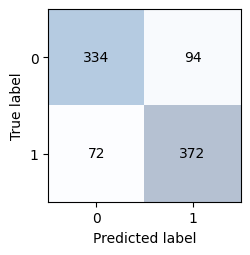

In [10]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

with open('./model/logistic_regression_model.pkl', 'rb') as f:
    model = pickle.load(f)

train_pred = model.predict(X_dev)
confmat = confusion_matrix(y_true=dev_labels, y_pred=train_pred)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va="center", ha="center")

ax.xaxis.set_ticks_position("bottom")
plt.xlabel("Predicted label")
plt.ylabel("True label")

## 67. 精度の計測

学習したロジスティック回帰モデルの正解率、適合率、再現率、F1スコアを、学習データおよび検証データ上で計測せよ。

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculate_acc_precision_recall_f1(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return f"正解率：{acc:.4f}, 適合率：{precision:.4f}, 再現率：{recall:.4f}, F1スコア：{f1:.4f}"

with open('./model/logistic_regression_model.pkl', 'rb') as f:
    model = pickle.load(f)

train_pred = model.predict(X_train)
dev_pred = model.predict(X_dev)

print("学習データ")
print(calculate_acc_precision_recall_f1(train_labels, train_pred))
print("\n検証データ")
print(calculate_acc_precision_recall_f1(dev_labels, dev_pred))

学習データ
正解率：0.9424, 適合率：0.9431, 再現率：0.9544, F1スコア：0.9487

検証データ
正解率：0.8096, 適合率：0.7983, 再現率：0.8378, F1スコア：0.8176


## 68. 特徴量の重みの確認

学習したロジスティック回帰モデルの中で、重みの高い特徴量トップ20と、重みの低い特徴量トップ20を確認せよ。

In [31]:
with open('./model/logistic_regression_model.pkl', 'rb') as f:
    model = pickle.load(f)

feature_names = vec.get_feature_names_out()
weights = model.coef_[0]  # model.coef_は2次元配列で、coef_[0]がクラス1（positive）に関する重み

feature_weight_pairs = list(zip(feature_names, weights))

# 重みが大きい順（positiveに強く寄与）
top_positive = sorted(feature_weight_pairs, key=lambda x: x[1], reverse=True)[:20]
# 重みが小さい順（negativeに強く寄与）
top_negative = sorted(feature_weight_pairs, key=lambda x: x[1])[:20]

print("--- 重みの高い特徴量トップ20 ---")
for i,(word, weight) in enumerate(top_positive):
    print(f"{str(i+1).ljust(4)}{word:15s}{weight:.4f}")

print("\n--- 重みの低い特徴量トップ20 ---")
for i, (word, weight) in enumerate(top_negative):
    print(f"{str(i+1).ljust(4)}{word:15s}{weight:.4f}")

--- 重みの高い特徴量トップ20 ---
1   refreshing     3.4332
2   remarkable     3.4280
3   powerful       3.2230
4   hilarious      3.1823
5   beautiful      3.0012
6   wonderful      2.9737
7   prose          2.9279
8   terrific       2.8732
9   appealing      2.8571
10  enjoyable      2.8165
11  treat          2.8034
12  charmer        2.7524
13  vividly        2.7156
14  likable        2.6930
15  solid          2.6522
16  charming       2.6208
17  half-bad       2.6180
18  fascinating    2.6138
19  impressive     2.5980
20  intriguing     2.5649

--- 重みの低い特徴量トップ20 ---
1   lacking        -4.3349
2   lacks          -4.0796
3   worst          -3.9862
4   devoid         -3.6562
5   mess           -3.6219
6   failure        -3.5835
7   stupid         -3.3480
8   bore           -3.2578
9   flat           -3.2248
10  depressing     -3.2002
11  loses          -3.1751
12  waste          -3.1588
13  lack           -3.0612
14  squanders      -3.0372
15  hardly         -3.0254
16  none           -3.0210
17 

## 69. 正則化パラメータの変更

ロジスティック回帰モデルを学習するとき、正則化の係数（ハイパーパラメータ）を調整することで、学習時の適合度合いを制御できる。正則化の係数を変化させながらロジスティック回帰モデルを学習し、検証データ上の正解率を求めよ。実験の結果は、正則化パラメータを横軸、正解率を縦軸としたグラフにまとめよ。

C=0.0001, Accuracy=0.5206
C=0.001 , Accuracy=0.6812
C=0.01  , Accuracy=0.7546
C=0.1   , Accuracy=0.8005
C=1     , Accuracy=0.8096
C=10    , Accuracy=0.8200
C=100   , Accuracy=0.7947
C=1000  , Accuracy=0.7856
C=10000 , Accuracy=0.7844


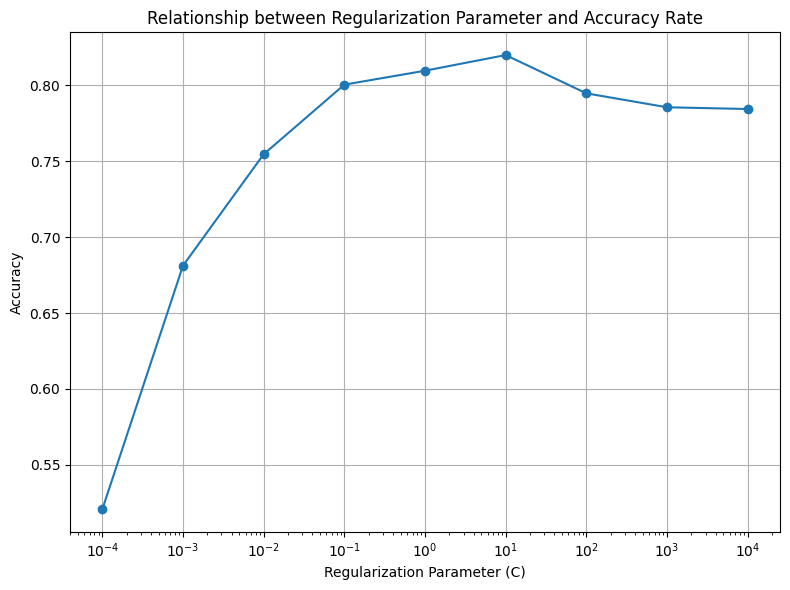

In [20]:
C_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
accuracies = []

for C in C_values:
    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, train_labels)
    y_pred = model.predict(X_dev)
    acc = accuracy_score(dev_labels, y_pred)
    accuracies.append(acc)
    print(f"C={str(C).ljust(6)}, Accuracy={acc:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(C_values, accuracies, marker="o")
plt.xscale("log")
plt.grid(True)
plt.title("Relationship between Regularization Parameter and Accuracy Rate")
plt.xlabel("Regularization Parameter (C)")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()